In [531]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

%matplotlib inline

sns.set()
sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 5})


# its possible to look at Confirmed,Recovered or Deaths simply by changing the filename below
# assign either of ['Confirmed','Deaths','Recovered'] to param below:


param = 'confirmed'

df_confirmed = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{}_global.csv'.format(
        param),sep=',',encoding='ISO8859-1')
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,11,16,21,22,22,22,24,24,40,40
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,38,42,51,55,59,64,70,76,89,104
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,37,48,54,60,74,87,90,139,201,230
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,2,39,39,53,75,88,113,133
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3


In [532]:
countries = df_confirmed.groupby('Country/Region')

### SELECT Country
s = countries.get_group('Sweden').iloc[:,4:].sum()
###

s.index = pd.to_datetime(s.index)
mask = s > 1
s = pd.DataFrame(s[mask],columns=['confirmed'])
s['log'] = np.log10(s['confirmed'])
s['day'] = np.arange(1,len(s) + 1).astype(int)
s['factor'] = s['confirmed'] / s['confirmed'].shift()
s

,confirmed,log,day,factor
2020-02-26,2,0.301030,1,NaN
2020-02-27,7,0.845098,2,3.500000
2020-02-28,7,0.845098,3,1.000000
2020-02-29,12,1.079181,4,1.714286
2020-03-01,14,1.146128,5,1.166667
2020-03-02,15,1.176091,6,1.071429
2020-03-03,21,1.322219,7,1.400000
2020-03-04,35,1.544068,8,1.666667
2020-03-05,94,1.973128,9,2.685714
2020-03-06,101,2.004321,10,1.074468


In [533]:
# PATCH missing days
'''
yesterday = pd.to_datetime('2020-03-13')
today = pd.to_datetime('2020-03-14')

y_data = [687,np.log10(687),17]
temp = pd.DataFrame({yesterday : y_data}).T
temp.columns=['confirmed','log','day']
s = s.append(temp)

y_data = [814,np.log10(814),18]
temp = pd.DataFrame({today : y_data}).T
temp.columns=['confirmed','log','day']
s = s.append(temp)
s['factor'] = (s['confirmed'] / s['confirmed'].shift())

s
'''

"\nyesterday = pd.to_datetime('2020-03-13')\ntoday = pd.to_datetime('2020-03-14')\n\ny_data = [687,np.log10(687),17]\ntemp = pd.DataFrame({yesterday : y_data}).T\ntemp.columns=['confirmed','log','day']\ns = s.append(temp)\n\ny_data = [814,np.log10(814),18]\ntemp = pd.DataFrame({today : y_data}).T\ntemp.columns=['confirmed','log','day']\ns = s.append(temp)\ns['factor'] = (s['confirmed'] / s['confirmed'].shift())\n\ns\n"

In [534]:
s.describe()

,confirmed,log,day,factor
count,27.000000,27.000000,27.000000,26.000000
mean,650.518519,2.278363,14.000000,1.374011
std,683.597856,0.921959,7.937254,0.555230
min,2.000000,0.301030,1.000000,1.000000
25%,28.000000,1.433144,7.500000,1.076461
50%,355.000000,2.550228,14.000000,1.173628
75%,1146.500000,3.059061,20.500000,1.406338
max,2046.000000,3.310906,27.000000,3.500000


Text(0.5, 1.0, 'Nr Infected [Log-10]')

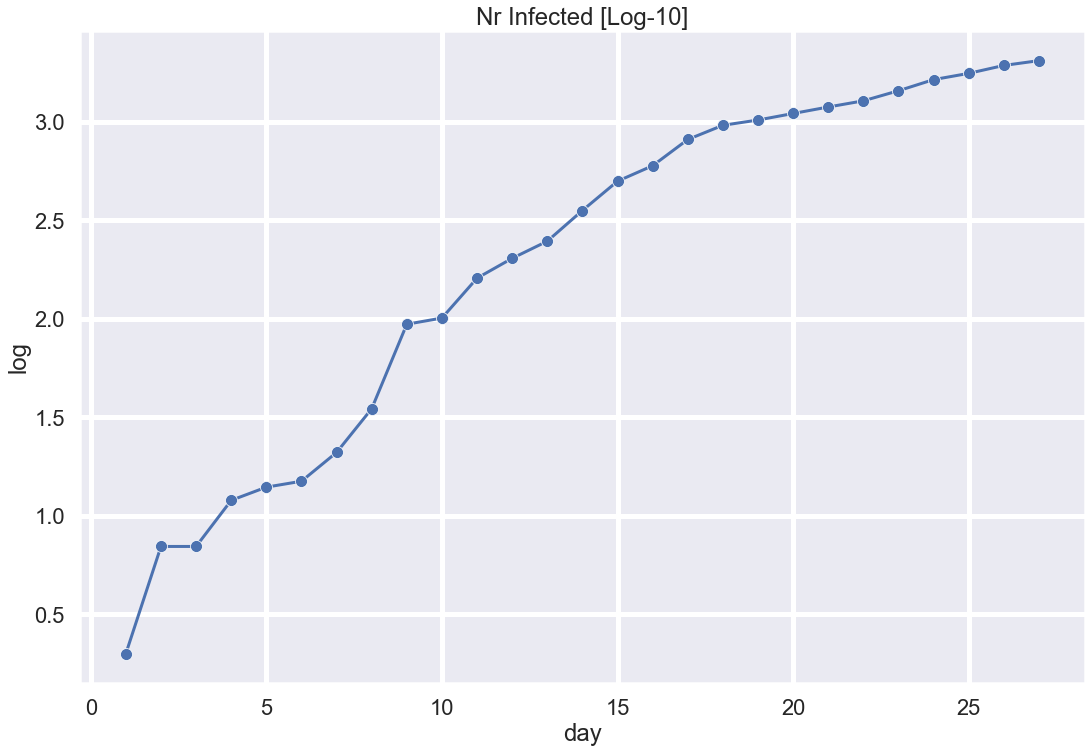

In [535]:
plt.figure(figsize=(18,12))
sns.lineplot(x=s['day'],y=s['log'],data=s,markers=True,marker='o').set_title('Nr Infected [Log-10]')

In [536]:
s['std_x'] = (s['day'] - s['day'].mean()) / s['day'].std()
s['std_y'] = (s['log'] - s['log'].mean()) / s['log'].std()
s['factor_log'] = np.log10(s['factor'])

### CUT SERIES to see trend as it was before limit testing ###
#s = s[-7:]
###
s

,confirmed,log,day,factor,std_x,std_y,factor_log
2020-02-26,2,0.301030,1,NaN,-1.637846,-2.144708,NaN
2020-02-27,7,0.845098,2,3.500000,-1.511858,-1.554586,0.544068
2020-02-28,7,0.845098,3,1.000000,-1.385870,-1.554586,0.000000
2020-02-29,12,1.079181,4,1.714286,-1.259882,-1.300689,0.234083
2020-03-01,14,1.146128,5,1.166667,-1.133893,-1.228075,0.066947
2020-03-02,15,1.176091,6,1.071429,-1.007905,-1.195576,0.029963
2020-03-03,21,1.322219,7,1.400000,-0.881917,-1.037078,0.146128
2020-03-04,35,1.544068,8,1.666667,-0.755929,-0.796451,0.221849
2020-03-05,94,1.973128,9,2.685714,-0.629941,-0.331073,0.429060
2020-03-06,101,2.004321,10,1.074468,-0.503953,-0.297239,0.031194


In [537]:
s.describe()

,confirmed,log,day,factor,std_x,std_y,factor_log
count,27.000000,27.000000,27.000000,26.000000,2.700000e+01,2.700000e+01,26.000000
mean,650.518519,2.278363,14.000000,1.374011,2.467162e-17,4.934325e-16,0.115764
std,683.597856,0.921959,7.937254,0.555230,1.000000e+00,1.000000e+00,0.128138
min,2.000000,0.301030,1.000000,1.000000,-1.637846e+00,-2.144708e+00,0.000000
25%,28.000000,1.433144,7.500000,1.076461,-8.189230e-01,-9.167647e-01,0.031998
50%,355.000000,2.550228,14.000000,1.173628,0.000000e+00,2.948776e-01,0.069523
75%,1146.500000,3.059061,20.500000,1.406338,8.189230e-01,8.467816e-01,0.148088
max,2046.000000,3.310906,27.000000,3.500000,1.637846e+00,1.119944e+00,0.544068


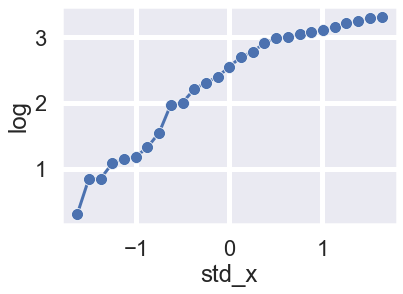

In [538]:
sns.lineplot(x='std_x',y='log',data=s,marker='o')

In [539]:
alpha_mu = 1.5
alpha_sigma = 5
beta_mu = 0
beta_sigma = 5
sigma_sigma = 0.000001 #0.0001

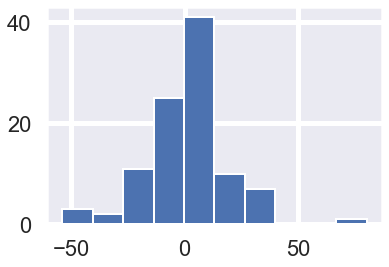

In [540]:
#simulate lines
nr_samples = 10000
nr_lines = 100

alpha = pm.rnormal(alpha_mu, 1 / alpha_sigma ** 2, nr_samples)
beta = pm.rnormal(beta_mu, 1 / beta_sigma ** 2, nr_samples)

#X = np.linspace(min(s['std_x']), max(s['std_x']),nr_lines)
# extend X over the data period
X = np.linspace(min(s['std_x']),max(s['std_x']) * 4, nr_lines)
                
alphas = np.random.choice(alpha,replace=True,size=nr_lines)
betas = np.random.choice(beta,replace=True,size=nr_lines)

def linreq_mu(x,alpha,beta):
    return x*beta+alpha

gen_factors = linreq_mu(X,alphas,betas)
_ = plt.hist(gen_factors)



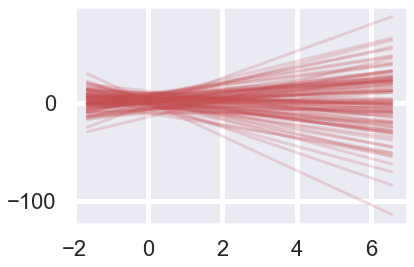

In [541]:
lines = np.array([X[i] * betas + alphas for i in range(len(X))])
_= plt.plot(X,lines,color='r',alpha=0.2)

In [542]:
alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu,tau = 1 / beta_sigma ** 2)

# by changing sigma from uniform to lognormal, the y-range of sample plot below
# shrunk a lot

sigma = pm.Lognormal('sigma',mu=0,tau = 1 / sigma_sigma ** 2)



@pm.deterministic()
def linreq_mu(x=s['std_x'],alpha=alpha,beta=beta):
    return x*beta+alpha

likelihood  = pm.Normal('likelihood',mu=linreq_mu,tau= 1 / sigma ** 2,
                       observed=True,value=s['log'])

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

mcmc.sample(100000,50000,2)

alpha_samples = mcmc.trace('alpha')[:]
beta_samples = mcmc.trace('beta')[:]
sigma_samples = mcmc.trace('sigma')[:]
linreq_mu_samples = mcmc.trace('sigma')[:]

result = pd.DataFrame({'alpha_post': alpha_samples,
                     'beta_post' : beta_samples,
                     'sigma_post' : sigma_samples,
                     'linreq_mu_post' : linreq_mu_samples})

result.describe()



 [-----------------100%-----------------] 100000 of 100000 complete in 186.6 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,25000.000000,25000.000000,2.500000e+04,2.500000e+04
mean,2.277040,0.885674,1.000000e+00,1.000000e+00
std,0.194869,0.198304,9.973913e-07,9.973913e-07
min,1.495118,0.138884,9.999964e-01,9.999964e-01
25%,2.145528,0.750970,9.999993e-01,9.999993e-01
50%,2.277067,0.883750,1.000000e+00,1.000000e+00
75%,2.410383,1.019105,1.000001e+00,1.000001e+00
max,3.107185,1.773081,1.000004e+00,1.000004e+00


In [543]:
alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_lines)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_lines)
sigmas = np.random.choice(result['sigma_post'],replace=True,size=nr_lines)

lines = np.array([X[i] * betas + alphas for i in range(len(X))])
print (lines.min(),lines.max())

0.09079082116703052 11.664500565937681


In [544]:
slope,intercept,_,_,_ = sps.linregress(s['std_x'],s['log'])
print (slope,intercept)

0.8889933971642044 2.2783632527070234


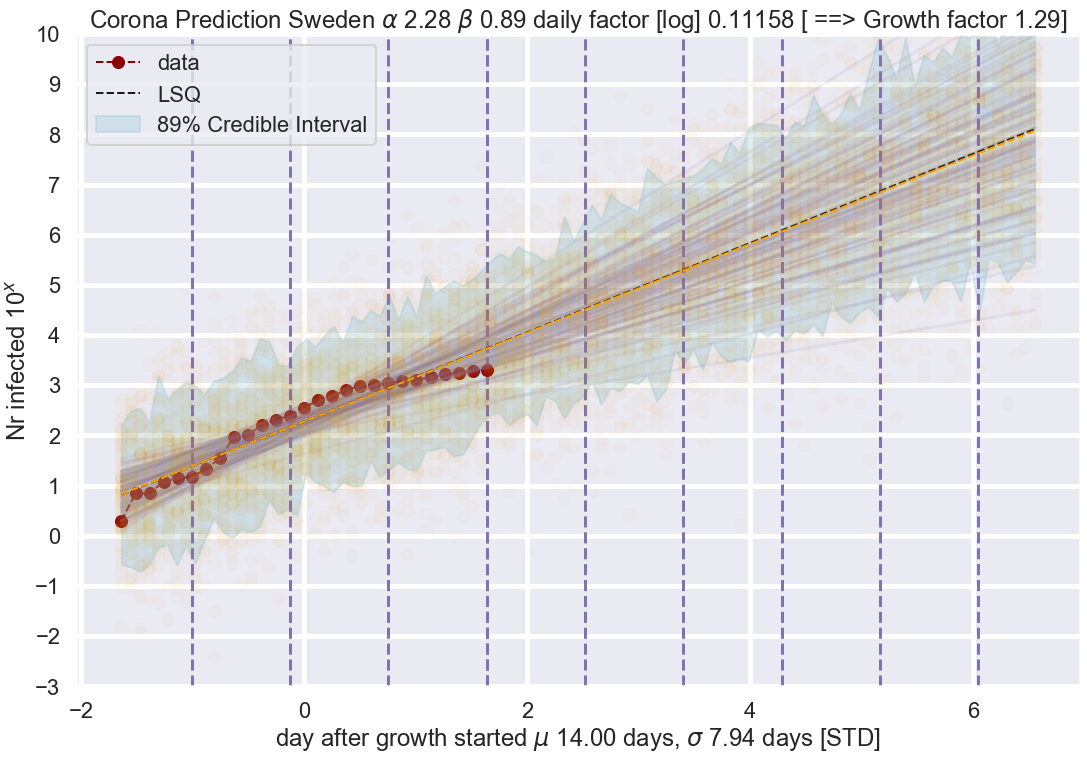

In [545]:
# lin/log plot - x standardized

plt.figure(figsize=(18,12))

daily_increase_log = result['beta_post'].mean() / s['day'].std()
daily_increase_lin = np.power(10,daily_increase_log)

title = r'Corona Prediction Sweden $\alpha$ {:.2f} $\beta$ {:.2f} '\
    'daily factor [log] {:.5f} [ ==> Growth factor {:.2f}]'.format(result['alpha_post'].mean(),
                                                            result['beta_post'].mean(),
                                                            daily_increase_log,
                                                            daily_increase_lin)
plt.title(title)

day_mean = s['day'].mean()
day_std = s['day'].std()
y_mean = s['log'].mean()
y_std = s['log'].std()

plt.xlabel(r'day after growth started $\mu$ {:.2f} days, $\sigma$ {:.2f} days [STD]'.format(day_mean,day_std))
plt.ylabel(r'Nr infected 10$^{x}$')

plt.ylim([-3,10])
plt.yticks(np.arange( -3,11 ,1))

#plt.axvline(max(s['std_x']),ls='dashed',color='k',label='last real data point')

week_in_std = 7 * 1 / s['day'].std()

week_bars = np.arange(max(s['std_x']),max(X),week_in_std)
for w in week_bars:
    plt.axvline(w,ls='dashed',color='m')
    
week_bars = np.arange(max(s['std_x']),min(X),-week_in_std)
for w in week_bars:
    plt.axvline(w,ls='dashed',color='m')
    

plt.plot(s['std_x'],s['log'],'o--',color='darkred',label='data',lw=2,ms=12)
plt.plot(X,lines,color='m',alpha=0.1)

plt.plot(X,[X[i] * slope + intercept for i in range(len(X))], 
         color='k',ls = 'dashed', label='LSQ',lw=2,alpha=1 )

plt.plot(X,[X[i] * betas.mean() + alphas.mean() for i in range(len(X))],
        color='orange',ls='dashed',lw=2)

# the rnormal returns a 2 x 2 matrix, with each row containing a complete line's yvals. 
samples = np.array(
    [pm.rnormal(X[i] * betas + alphas,sigmas) for i in range(len(X))])

low,high = np.percentile(samples,[5.5,94.5],axis=1)
last_low,last_high = low[-1],high[-1]


plt.fill_between(np.linspace(min(X),max(X),high.size),
                low,high,color='c',alpha=0.2,label='89% Credible Interval')

for i in range(len(X)):
    plt.plot(X,samples[:,i],'o',color='orange',alpha=0.02)
plt.legend(loc='upper left')
plt.savefig('corona_prediction_lin_log.jpg',format='jpg')